In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import yaml
import numpy as np
from tqdm.notebook import tqdm
import itertools
import math
import datetime

## Fluxograma da limpeza de dados

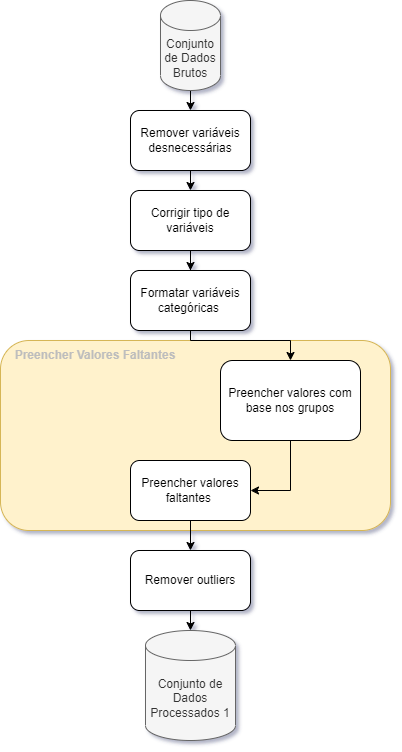

## Carregar conjunto de dados

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MedicinIA/Sample_Data/Raw/DataSet1.csv')
with open('/content/drive/MyDrive/MedicinIA/Sample_Data/Raw/DataSet1.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
numerical = config['NumericalColumns']
categorical = config['CategoricalColumns']
identifier = config['IdentifierColumns']
datetime = config['DateTimeColumns']
target = config['Target']

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (22,24,25,75,76,77,78,89,90,91,92) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Remover colunas desnecessárias

### Colunas uma quantidade irrelevante de valores não nulos 

In [ ]:
TO_DROP = ['partos', 'daughter_n', 'tempo_rep_hormo_tasy', 'hormone_therapy_tasy']
data.drop(TO_DROP, axis=1, inplace=True)

numerical.remove('partos')
numerical.remove('daughter_n')
categorical.remove('tempo_rep_hormo_tasy')
categorical.remove('hormone_therapy_tasy')

## Corrigir colunas com mais de um tipo

### Variáveis categóricas com o tipo errado

In [ ]:
FIX_TYPES = [
    'antec_fam_cancer_mama',
    'rec01',
    'rec02',
    'rec03',
    'rec04',
    'meta01',
    'meta02',
    'meta03',
    'meta04']

data[FIX_TYPES] = data[FIX_TYPES].astype('string')

## Remover decimal de variáveis categóricas.

#### Algumas variáveis categóricas(que deveriam ser strings(textos)) possuem casas após a vírgula, portanto, faz-se necessária a remoção das mesmas.

In [ ]:
REMOVE_DECIMALS = [
    'escolari',
    'race',
    'pregnancy_history',
    'abortion',
    'breast_feeding',
    'period',
    'contraceptive_method___1',
    'contraceptive_method___2',
    'contraceptive_method___3',
    'contraceptive_method___4',
    'contraceptive_method___999',
    'hormone_therapy',
    'tobaco',
    'alcohol',
    'tobaco_type',
    'alcohol_type___1',
    'alcohol_type___2',
    'alcohol_type___3',
    'family_cancer',
    'familial_degree___1',
    'familial_degree___2',
    'familial_degree___3',
    'family_cancer_id___1',
    'family_cancer_id___2',
    'family_cancer_id___3',
    'family_cancer_id___4',
    'family_cancer_id___5',
    'family_cancer_id___6',
    'mother_tumor',
    'mother_tumor',
    'sister_tumor_1',
    'daughter_tumor_1',
    'birads',
    'benign',
    'primary_diganosis',
    'diff_tubular', 
    'nuclear_grade',
    'mitotic_index',
    'histological_grade',
    'grau_hist',
    'tumor_margin',
    'er_ihc',
    'pr_ihc',
    'tumor_subtype',
    'her2_ihc',
    'her2_fish',
    'ultinfo',
    'recidive',
    'reclocal',
    'recregio',
    'recdist',
    'trathosp',
    'trathosp',
    'topo',
    'rec01',
    'rec02',
    'rec03',
    'morfo',
    'm',
    't',
    'n',
    'tumor_stage',
    'tipotrat',
    'treatment',
    'chemotherapy']

for c in REMOVE_DECIMALS:
    data[c] = data[c].astype('string').apply(
        lambda x: x if pd.isna(x) else x[:x.find('.')])
    data[c] = data[c].astype('string')

## Preencher valores faltantes

In [ ]:
data.redcap_repeat_instance.unique()

array([nan,  2.,  3.,  1.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96.])

In [ ]:
data.redcap_repeat_instance.fillna(-1, inplace=True)

In [ ]:
for col in datetime:
    col = list(col.keys())[0]
    data[col] = data[col].fillna(0)

### Substituição dos valores nulos pela métrica definida para o respectivo record_id

In [ ]:
def fill_na_by_group(df, id, col, agg_func = 'last'):
    """Preenche valores faltantes dos grupos com uma função de agregação.
    
    Args: 
        df: Instância de um pd.DataFrame representando um conjunto de dados.
        id: Coluna a ser utilizada como identificador para agrupamento.
        col: Coluna a ser preenchida e aplicada a função de agregação.
        agg_func: String representando a função de agregação. O valor padrão é
          'last'.
    
    Returns:
        Uma instância de pd.DataFrame com os dados preenchidos.
    """
    def fill(x):
        element = x[col]
        if pd.isnull(element):
            x[col] = x['unique_col']
        return x

    unique = df[[id, col]].dropna(subset=[col]).groupby(id).agg(
        unique_col = (col, agg_func))

    df = pd.merge(df, unique, left_on=id, right_index=True, how='left')

    df = df.apply(fill, axis=1)
    df.drop('unique_col', inplace = True, axis = 1)
    return df

#### Preenchimento de acordo com o **último** registro na base de dados


In [ ]:
data = fill_na_by_group(data, 'record_id', 'follow_up_days_recidive', 'last')
data.follow_up_days_recidive.fillna(-1, inplace = True)

In [ ]:
data = fill_na_by_group(data, 'record_id', 'follow_up_days', 'last')
data.follow_up_days.fillna(-1, inplace = True)

In [ ]:
data = fill_na_by_group(data, 'record_id', 'sister_n', 'last')
data.sister_n.fillna(-1, inplace = True)

#### Preenchimento de acordo com o **maior** valor registrado na base de dados

In [ ]:
data = fill_na_by_group(data, 'record_id', 'ki67_perc', 'max')
data.ki67_perc.fillna(-1, inplace = True)

In [ ]:
data = fill_na_by_group(data, 'record_id', 'tumor_subtype', 'max')
data.tumor_subtype.fillna(-1, inplace = True)

#### Preenchimento de acordo com a **mediana** dos valores registrados na base de dados

In [ ]:
data = fill_na_by_group(data, 'record_id', 'bmi', 'median')
data.bmi.fillna(-1, inplace = True)

#### Preenchimento de acordo com a **média** dos valores registrados na base de dados

In [ ]:
data = fill_na_by_group(data, 'record_id', 'height', 'mean')
data.height.fillna(-1, inplace = True)

In [ ]:
data = fill_na_by_group(data, 'record_id', 'weight', 'mean')
data.weight.fillna(-1, inplace = True)

### Substituição dos valores nulos das variáveis categóricas pela **última instância** do elemento

In [ ]:
def fill_na_categories(series, symbols, value='Não informado'):
    series.fillna(value, inplace=True)
    for s in symbols:
        series.replace(s, value, inplace=True) 
    return series

def last_categories(series):
    series = series.dropna()
    series = series[series != '']
    values = series.values
    l = len(values)
    if l == 0:
        return ''
    if l == 1:
        return values[0]

    return values[l-1] 

for col in tqdm(categorical):
    data = fill_na_by_group(data, 'record_id', col, last_categories)
    data[col] = fill_na_categories(data[col], ['', 'N/A'])

  0%|          | 0/70 [00:00<?, ?it/s]

## Clipar intervalo de variáveis

In [ ]:
data.bmi.clip(
    lower=data.bmi.quantile(0.01),
    upper=45,inplace=True)

In [ ]:
data.height.clip(
    lower=data.height.quantile(0.01), inplace=True
)

## Escrever dados

In [ ]:
dt = list(map(lambda x: list(x.keys())[0], datetime))
data[numerical + categorical + dt + identifier + [target]].to_csv('/content/drive/MyDrive/MedicinIA/Sample_Data/Processed/DataSet1.csv', index=False)